# Instructions: 
1. For feature selections, run generate_train_test(*lag*, *weekly/monthly/daily*, *datasets used*) to generate training and testing dataset 
2. Uncomment .tocsv lines in the function to transform training and testing df to csv files.
3. Refer to last line of code for example

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,SCORERS,roc_auc_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

In [126]:
# datasets chosen - tech companies
df_aapl = pd.read_csv('../datasets/stocks/AAPL.csv')
df_ggl = pd.read_csv('../datasets/stocks/GOOGL.csv')
df_msft = pd.read_csv('../datasets/stocks/MSFT.csv')

Text(0, 0.5, 'Close Price')

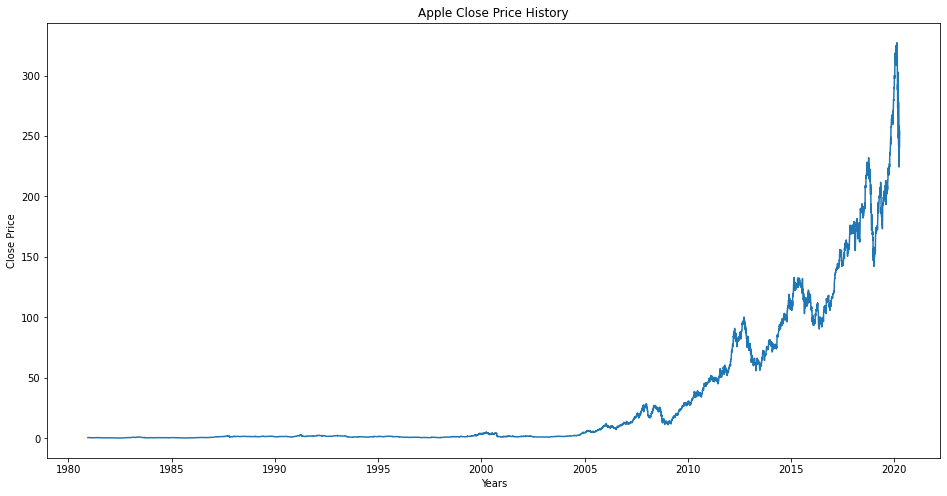

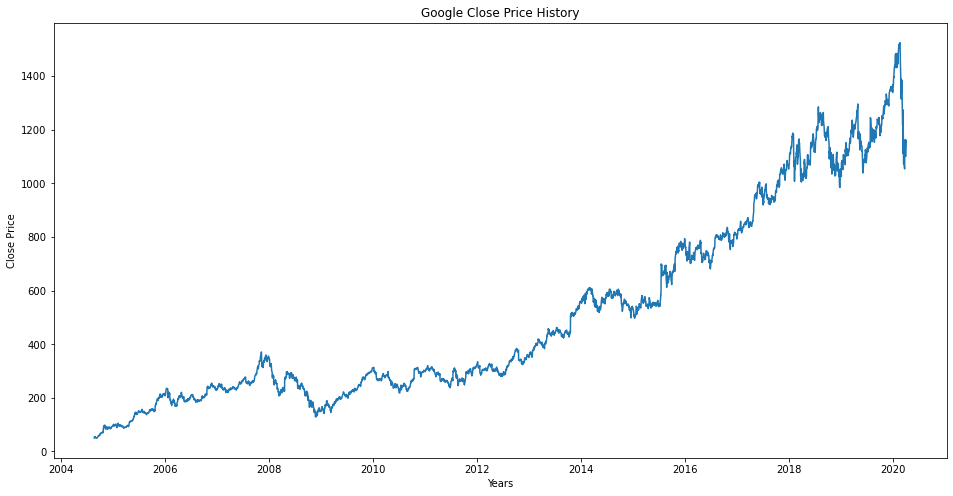

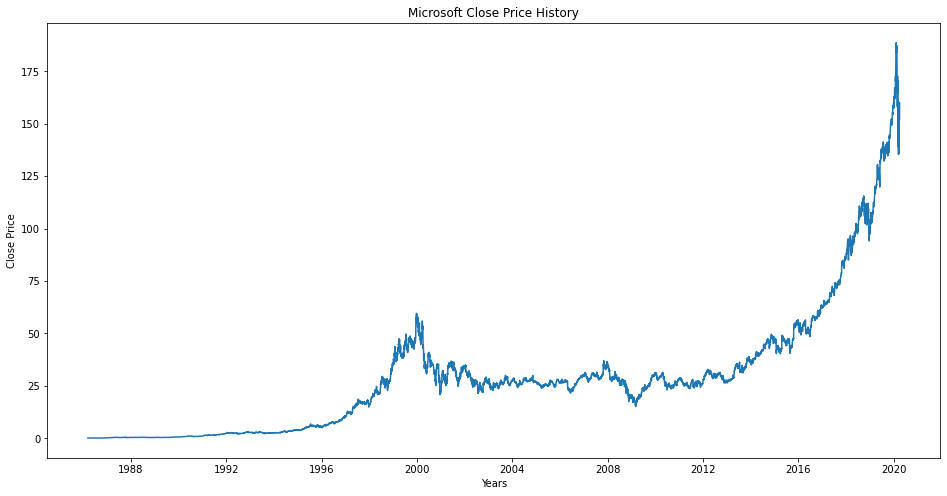

In [127]:
# apple
df_aapl['Date'] = pd.to_datetime(df_aapl.Date,format='%Y-%m-%d')
df_aapl.index = df_aapl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_aapl['Close'])
plt.title("Apple Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# google
df_ggl['Date'] = pd.to_datetime(df_ggl.Date,format='%Y-%m-%d')
df_ggl.index = df_ggl['Date']
plt.figure(figsize=(16,8))
plt.plot(df_ggl['Close'])
plt.title("Google Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

# microsoft
df_msft['Date'] = pd.to_datetime(df_msft.Date,format='%Y-%m-%d')
df_msft.index = df_msft['Date']
plt.figure(figsize=(16,8))
plt.plot(df_msft['Close'])
plt.title("Microsoft Close Price History")
plt.xlabel("Years")
plt.ylabel("Close Price")

In [128]:
def split(df):
    train_size = round(len(df)*0.7)
    y_movement = df['movement']
    y_t = df['Close (t)']
    X_colnames = df.drop(['Close (t)', 'movement'], axis=1).columns
    X = df[X_colnames]

    # for movement
    X_train, X_test, y_train_movement, y_test_movement = X[:train_size], X[train_size:], y_movement[:train_size], y_movement[train_size:]

    # for t
    X_train, X_test, y_train_t, y_test_t = X[:train_size], X[train_size:], y_t[:train_size], y_t[train_size:]
    train_df = pd.concat([X_train,y_train_t,y_train_movement],axis = 1)
    test_df = pd.concat([X_test,y_test_t, y_test_movement],axis = 1)
    return train_df, test_df

In [129]:
def shift(df, n):
    new_df = pd.DataFrame()
    # volume
    vol = "Volume (t-"+str(n)+")"
    new_df[vol] = df['Volume']
    for i in range(n-1,0,-1):
        v = "Volume (t-"+str(i)+")"
        new_df[v] = df['Volume'].shift(-(n-i))

    # close price
    p = "Close (t-"+str(n)+")"
    new_df[p] = df['Close']
    for i in range(n-1,0,-1):
        v = "Close (t-"+str(i)+")"
        new_df[v] = df['Close'].shift(-(n-i))

    # y-variable (close price)
    new_df['Close (t)'] = df['Close'].shift(-n)
    new_df = new_df.dropna()

    # y-variable (movement)
    new_df['movement'] = np.where(new_df["Close (t)"] > new_df['Close (t-1)'], 1, 0)
    return new_df


In [130]:
# Automate pipeline to generate training and testing datasets based on lag
def generate_train_test(lag, datasets, avg = "weekly"):
    """
    Return the training and testing dataset, uncomment to transform df to csv after feature selections
    """
    train_all = pd.DataFrame()
    test_all = pd.DataFrame()
    for df in datasets:
        if avg == "weekly":
            df = df.resample('W').mean()
        elif avg == "monthly":
            df = df.resample('M').mean()
        #else, daily, noneed groupby
        df = shift(df, lag)
        train_df, test_df = split(df)
        train_all = pd.concat([train_all, train_df])
        test_all = pd.concat([test_all, test_df])
    #train_all.to_csv(str(lag)+"_"+avg+"_train.csv")
    #test_all.to_csv(str(lag)+"_"+avg+"_test.csv")
    return train_all, test_all


In [131]:
# Remove data where price stagnant
df_aapl = df_aapl[(df_aapl['Date'] >= '2005-01-01')]
df_msft = df_msft[(df_msft['Date'] >= '1998-01-01')]

## XGB on Stock

In [132]:
#!pip install xgboost
def XGB(name, df_stock, lag, aggr_fun='weekly'):
    import xgboost as xgb
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    import xgboost as xgb
    params = {'max_depth': [3,4,5], 
              'learning_rate': [x/10 for x in list(range(1,6))],
              'n_estimators': [30, 35, 50]}
    model_stock = xgb.XGBRegressor(random_state=42, reg_lambda=200)
    model_stock = GridSearchCV(model_stock, params, scoring='neg_root_mean_squared_error')
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)
    print(model_stock.best_estimator_)
    
    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    print(name, aggr_fun.capitalize(), 'RMS:', rms_stock)

    # plot train
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = train_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = model_stock.predict(x_train_stock)

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag)+"(train)")
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    # plot test
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag))
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    print(confusion_matrix(move_test_stock, pred_move_stock))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    
    return rms_stock, precision, recall, accuracy, f1
    

## GB on Stock

In [133]:
def GB(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    model_stock = GradientBoostingRegressor(random_state=42)
    params = {
        'learning_rate': [x/10 for x in list(range(1,6))],
        'max_depth': [3, 4, 5]
        }
    model_stock = GridSearchCV(model_stock, params, scoring='neg_root_mean_squared_error')
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)
    print(model_stock.best_estimator_)
    
    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    print(name, aggr_fun.capitalize(), 'RMS:', rms_stock)

    # plot train
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = train_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = model_stock.predict(x_train_stock)

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag)+"(train)")
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    # plot test
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag))
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    print(confusion_matrix(move_test_stock, pred_move_stock))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    
    return rms_stock, precision, recall, accuracy, f1
    

## Simple Decision Tree Regressor on Stock

In [134]:
def DT(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    model_stock = DecisionTreeRegressor(random_state=42)
    params = {
        'max_depth': [3, 4, 5]
        }
    model_stock = GridSearchCV(model_stock, params, scoring='neg_root_mean_squared_error')
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)
    print(model_stock.best_estimator_)
    
    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    print(name, aggr_fun.capitalize(), 'RMS:', rms_stock)

    # plot train
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = train_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = model_stock.predict(x_train_stock)

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag)+"(train)")
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    # plot test
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag))
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    print(confusion_matrix(move_test_stock, pred_move_stock))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    
    return rms_stock, precision, recall, accuracy, f1

## Random Forest Regressor on Stock

In [135]:
def rf(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    model_stock = RandomForestRegressor(random_state=42)
    params = {
        'max_depth': [3, 4, 5]
        }
    model_stock = GridSearchCV(model_stock, params, scoring='neg_root_mean_squared_error')
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)
    print(model_stock.best_estimator_)
    
    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    print(name, aggr_fun.capitalize(), 'RMS:', rms_stock)

    # plot train
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = train_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = model_stock.predict(x_train_stock)

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag)+"(train)")
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    # plot test
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = test_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = preds_stock

    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'])
    plt.plot(df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'])

    plt.title(name+' '+aggr_fun.capitalize()+' with sliding window '+str(lag))
    
    plt.ylabel('Close',fontsize=18)
    plt.legend([name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)', name+' '+aggr_fun.capitalize()+' Price Prediction'])
    plt.show()

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    
    print(confusion_matrix(move_test_stock, pred_move_stock))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    print("metrics.roc_auc_score", str(roc_auc_score(move_test_stock, pred_move_stock)))
    
    return rms_stock, precision, recall, accuracy, f1

## Compare between Models fixed at lag 4 (One Month)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=200, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Apple Weekly RMS: 70.45573650830306


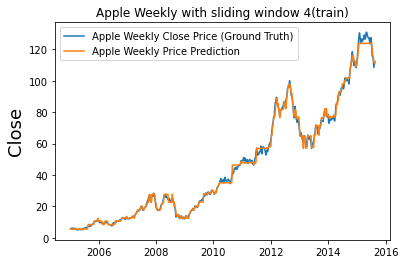

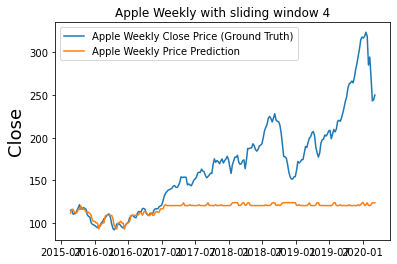

[[ 72  21]
 [127  18]]
Precision: 0.462
Recall: 0.124
Accuracy: 0.378
F1-score: 0.196



(70.45573650830306,
 0.46153846153846156,
 0.12413793103448276,
 0.37815126050420167,
 0.19565217391304346)

In [136]:
# ~ one month lag
XGB(name='Apple', df_stock=[df_aapl], lag=4)

GradientBoostingRegressor(learning_rate=0.2, random_state=42)
Apple Weekly RMS: 65.56279528194355


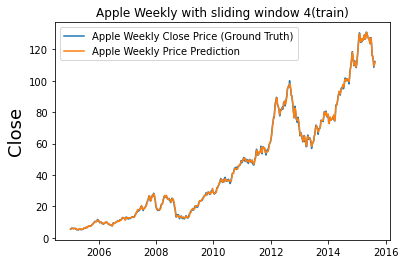

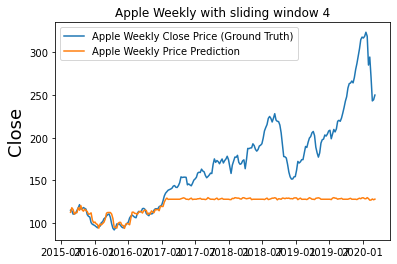

[[ 68  25]
 [124  21]]
Precision: 0.457
Recall: 0.145
Accuracy: 0.374
F1-score: 0.220



(65.56279528194355,
 0.45652173913043476,
 0.14482758620689656,
 0.3739495798319328,
 0.21989528795811522)

In [137]:
GB(name='Apple', df_stock=[df_aapl], lag=4)

RandomForestRegressor(max_depth=5, random_state=42)
Apple Weekly RMS: 65.95565496282866


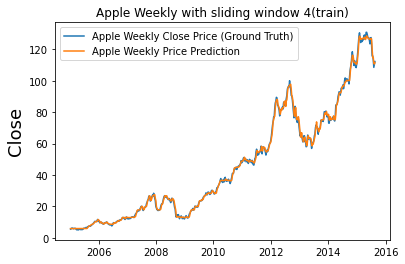

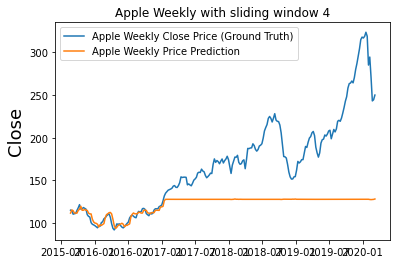

[[ 71  22]
 [123  22]]
Precision: 0.500
Recall: 0.152
Accuracy: 0.391
F1-score: 0.233

metrics.roc_auc_score 0.45758249907304416


(65.95565496282866,
 0.5,
 0.15172413793103448,
 0.3907563025210084,
 0.23280423280423282)

In [138]:
rf(name='Apple', df_stock=[df_aapl], lag=4)

DecisionTreeRegressor(max_depth=5, random_state=42)
Apple Weekly RMS: 65.13487308722


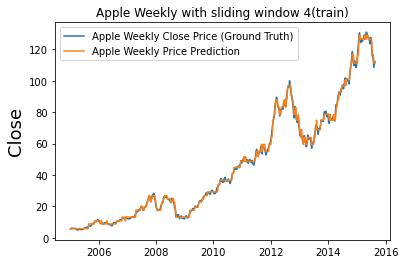

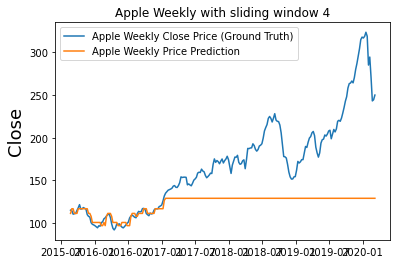

[[ 68  25]
 [120  25]]
Precision: 0.500
Recall: 0.172
Accuracy: 0.391
F1-score: 0.256



(65.13487308722,
 0.5,
 0.1724137931034483,
 0.3907563025210084,
 0.25641025641025644)

In [139]:
DT(name='Apple', df_stock=[df_aapl], lag=4)

## Compare between different lags (simple DT chosen)

### Apple

DecisionTreeRegressor(max_depth=5, random_state=42)
Apple Weekly RMS: 65.13487308722


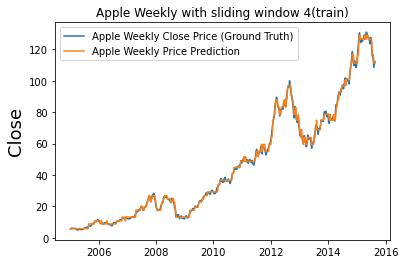

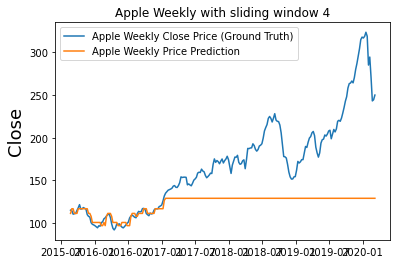

[[ 68  25]
 [120  25]]
Precision: 0.500
Recall: 0.172
Accuracy: 0.391
F1-score: 0.256



(65.13487308722,
 0.5,
 0.1724137931034483,
 0.3907563025210084,
 0.25641025641025644)

In [140]:
# ~ one month lag
DT(name='Apple', df_stock=[df_aapl], lag=4)

DecisionTreeRegressor(max_depth=4, random_state=42)
Apple Weekly RMS: 66.63908395977819


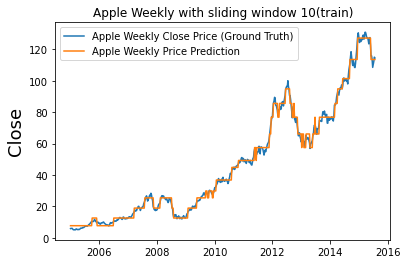

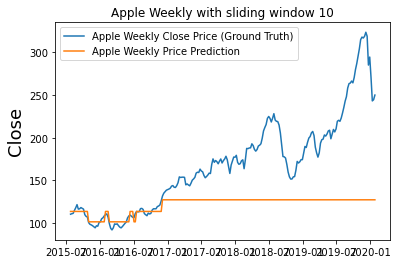

[[ 72  20]
 [120  24]]
Precision: 0.545
Recall: 0.167
Accuracy: 0.407
F1-score: 0.255



(66.63908395977819,
 0.5454545454545454,
 0.16666666666666666,
 0.4067796610169492,
 0.2553191489361702)

In [141]:
DT(name='Apple', df_stock=[df_aapl], lag=10)

DecisionTreeRegressor(max_depth=5, random_state=42)
Apple Weekly RMS: 65.46480215374996


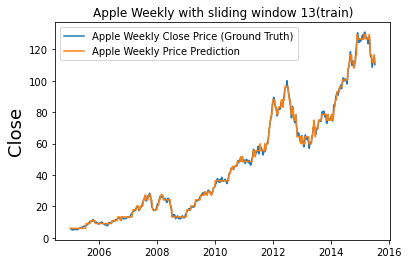

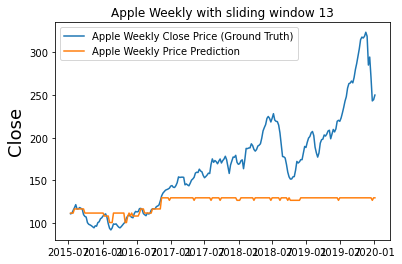

[[ 68  23]
 [118  26]]
Precision: 0.531
Recall: 0.181
Accuracy: 0.400
F1-score: 0.269



(65.46480215374996,
 0.5306122448979592,
 0.18055555555555555,
 0.4,
 0.2694300518134715)

In [142]:
# ~ one quarter
DT(name='Apple', df_stock=[df_aapl], lag=13)

4 weeks (one month) > 13 weeks > 10 weeks

## Google

DecisionTreeRegressor(max_depth=5, random_state=42)
Google Weekly RMS: 440.3985388005147


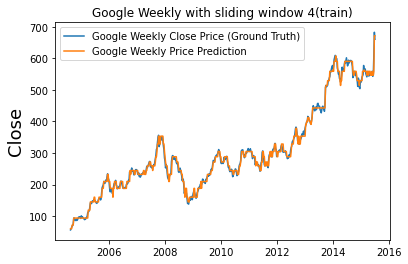

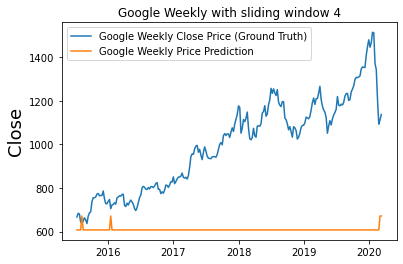

[[ 99   1]
 [144   0]]
Precision: 0.000
Recall: 0.000
Accuracy: 0.406
F1-score: 0.000



(440.3985388005147, 0.0, 0.0, 0.4057377049180328, 0.0)

In [143]:
DT(name='Google', df_stock=[df_ggl], lag=4)

DecisionTreeRegressor(max_depth=5, random_state=42)
Google Weekly RMS: 388.1929097559844


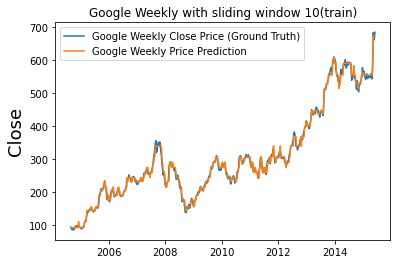

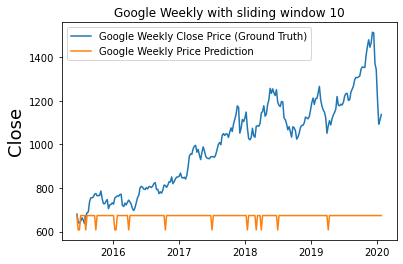

[[ 98   2]
 [139   3]]
Precision: 0.600
Recall: 0.021
Accuracy: 0.417
F1-score: 0.041



(388.1929097559844,
 0.6,
 0.02112676056338028,
 0.41735537190082644,
 0.04081632653061224)

In [144]:
DT(name='Google', df_stock=[df_ggl], lag=10)

DecisionTreeRegressor(max_depth=5, random_state=42)
Google Weekly RMS: 385.5176445163337


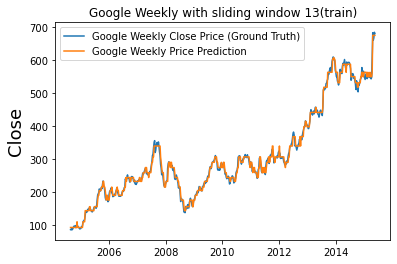

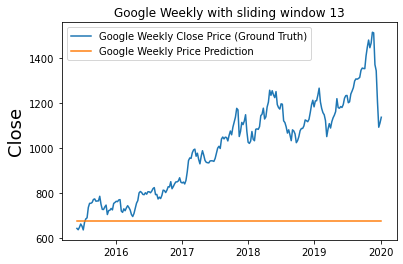

[[ 96   3]
 [138   4]]
Precision: 0.571
Recall: 0.028
Accuracy: 0.415
F1-score: 0.054



(385.5176445163337,
 0.5714285714285714,
 0.028169014084507043,
 0.4149377593360996,
 0.053691275167785234)

In [145]:
DT(name='Google', df_stock=[df_ggl], lag=13)

## Microsoft

DecisionTreeRegressor(max_depth=5, random_state=42)
Microsoft Weekly RMS: 41.80347447086741


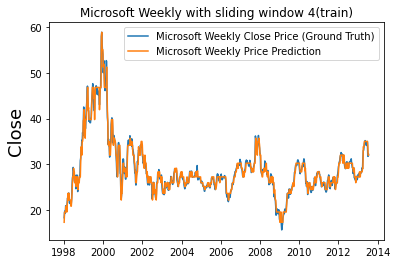

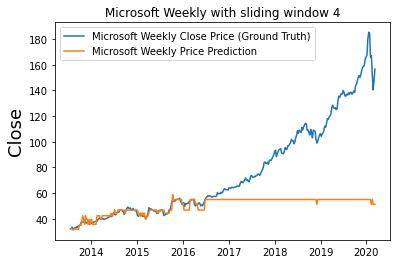

[[100  34]
 [153  60]]
Precision: 0.638
Recall: 0.282
Accuracy: 0.461
F1-score: 0.391



(41.80347447086741,
 0.6382978723404256,
 0.28169014084507044,
 0.4610951008645533,
 0.39087947882736157)

In [146]:
DT(name='Microsoft', df_stock=[df_msft], lag=4)

DecisionTreeRegressor(max_depth=5, random_state=42)
Microsoft Weekly RMS: 44.83910795745575


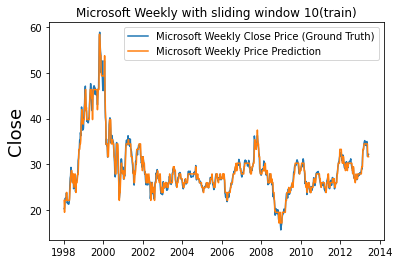

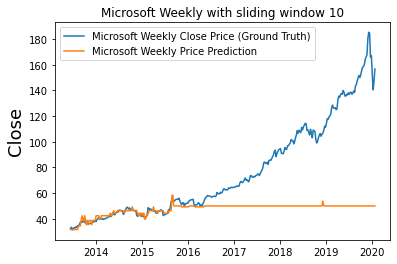

[[112  22]
 [160  52]]
Precision: 0.703
Recall: 0.245
Accuracy: 0.474
F1-score: 0.364



(44.83910795745575,
 0.7027027027027027,
 0.24528301886792453,
 0.47398843930635837,
 0.3636363636363636)

In [147]:
DT(name='Microsoft', df_stock=[df_msft], lag=10)

DecisionTreeRegressor(max_depth=5, random_state=42)
Microsoft Weekly RMS: 42.60901090611907


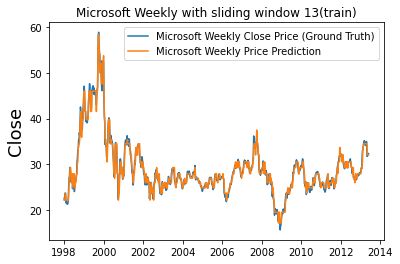

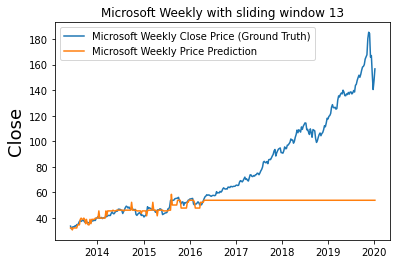

[[112  22]
 [164  47]]
Precision: 0.681
Recall: 0.223
Accuracy: 0.461
F1-score: 0.336



(42.60901090611907,
 0.6811594202898551,
 0.22274881516587677,
 0.4608695652173913,
 0.3357142857142857)

In [148]:
DT(name='Microsoft', df_stock=[df_msft], lag=13)

DecisionTreeRegressor(max_depth=5, random_state=42)
Microsoft Daily RMS: 43.12372465763494


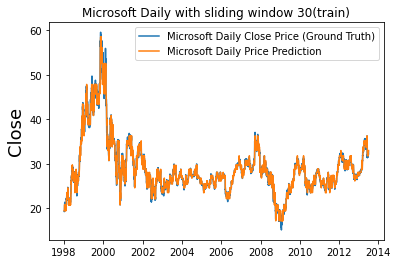

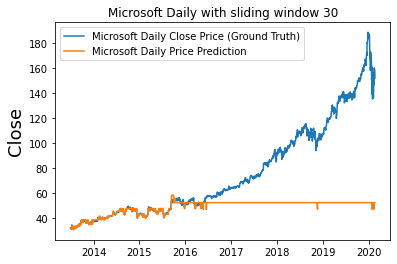

[[594 187]
 [686 203]]
Precision: 0.521
Recall: 0.228
Accuracy: 0.477
F1-score: 0.317



(43.12372465763494,
 0.5205128205128206,
 0.2283464566929134,
 0.47724550898203594,
 0.3174354964816263)

In [149]:
DT(name='Microsoft', df_stock=[df_msft], lag=30, aggr_fun='daily')

DecisionTreeRegressor(max_depth=5, random_state=42)
Microsoft Daily RMS: 39.50692773042306


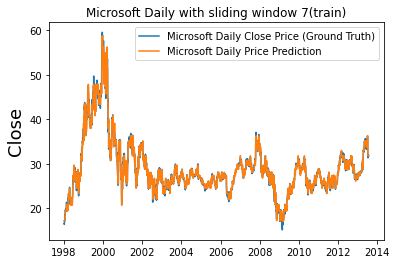

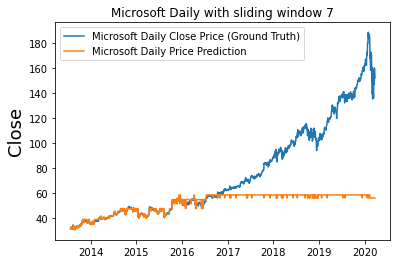

[[548 237]
 [620 272]]
Precision: 0.534
Recall: 0.305
Accuracy: 0.489
F1-score: 0.388



(39.50692773042306,
 0.5343811394891945,
 0.30493273542600896,
 0.48896839594514013,
 0.3882940756602427)

In [150]:
DT(name='Microsoft', df_stock=[df_msft], lag=7, aggr_fun='daily')

## Plot against performance & lag

In [151]:
def DT_clean(name, df_stock, lag, aggr_fun='weekly'):
    train_stock, test_stock = generate_train_test(lag, df_stock, aggr_fun)

    model_stock = DecisionTreeRegressor(random_state=42)
    params = {
        'max_depth': [3, 4, 5]
        }
    model_stock = GridSearchCV(model_stock, params, scoring='neg_root_mean_squared_error')
    x_train_stock = train_stock.drop(['Close (t)', 'movement'], axis=1)
    y_train_stock = train_stock['Close (t)']
    model_stock.fit(x_train_stock, y_train_stock)
    
    # features should exclude 'movement' and 'Close (t)'
    x_test_stock = test_stock.drop(['Close (t)', 'movement'], axis=1)
    y_test_stock = test_stock['Close (t)']

    preds_stock = model_stock.predict(x_test_stock)
    rms_stock = np.sqrt(np.mean(np.power((np.array(y_test_stock)-np.array(preds_stock)),2)))

    # plot train
    df_results = pd.DataFrame()
    df_results[name+' '+aggr_fun.capitalize()+' Close Price (Ground Truth)'] = train_stock['Close (t)']
    df_results[name+' '+aggr_fun.capitalize()+' Price Prediction'] = model_stock.predict(x_train_stock)

    move_test_stock = test_stock['movement']

    pred_move_stock = (preds_stock - test_stock["Close (t-1)"]) 
    pred_move_stock = pred_move_stock.where(pred_move_stock<0, 1).where(pred_move_stock>=0, 0).astype(int)

    precision = precision_score(move_test_stock, pred_move_stock)
    recall = recall_score(move_test_stock, pred_move_stock)
    accuracy = accuracy_score(move_test_stock, pred_move_stock)
    f1 = f1_score(move_test_stock, pred_move_stock)
    roc = roc_auc_score(move_test_stock, pred_move_stock)
    
    return rms_stock, precision, recall, accuracy, f1, roc
    

In [152]:
def plot_lag_to_performance(name, df_stock, aggr_fun='weekly'):
    rmss = []
    precisions = []
    recalls = []
    accuracies = []
    f1_scores = []
    auc = []

    lag_range = [i for i in range(1, 53)]
    
    # get performance df
    for i in lag_range:
        rms_stock, precision, recall, accuracy, f1_score, auc_score = DT_clean(name, df_stock, i, aggr_fun='weekly')
        rmss.append(rms_stock)
        precisions.append(precision)
        recalls.append(recall)
        accuracies.append(accuracy)
        f1_scores.append(f1_score)
        auc.append(auc_score)

    performances_arr = np.transpose(np.array([rmss, precisions, recalls, accuracies, f1_scores, auc]))
    per_str = ['rmss', 'precisions', 'recalls', 'accuracies', 'f1_scores', 'roc auc']
    df_perform = pd.DataFrame(data=performances_arr, index=lag_range, columns=per_str)
    
    # plotting performance against lag
    values = df_perform.values
    groups = range(0,6)
    i = 1
    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df_perform.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()
    
    return df_perform

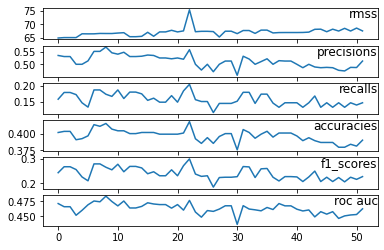

In [153]:
df_perform_aapl = plot_lag_to_performance(name='Apple', df_stock=[df_aapl])

In [154]:
best_aapl = df_perform_aapl[df_perform_aapl["accuracies"] == max(df_perform_aapl["accuracies"])]  # 23 (5 months)
df_perform_aapl

,rmss,precisions,recalls,accuracies,f1_scores,roc auc
1,64.983233,0.534884,0.157534,0.401674,0.243386,0.471240
2,65.140184,0.530612,0.179310,0.403361,0.268041,0.465999
3,65.140184,0.530612,0.179310,0.403361,0.268041,0.465999
4,65.134873,0.500000,0.172414,0.390756,0.256410,0.451798
5,66.536769,0.500000,0.145833,0.392405,0.225806,0.460013
6,66.509753,0.513514,0.131944,0.396624,0.209945,0.469198
7,66.523038,0.551020,0.187500,0.413502,0.279793,0.475470
8,66.663993,0.551020,0.187500,0.411017,0.279793,0.474185
9,66.640809,0.568182,0.173611,0.415254,0.265957,0.483545
10,66.639084,0.545455,0.166667,0.406780,0.255319,0.474638


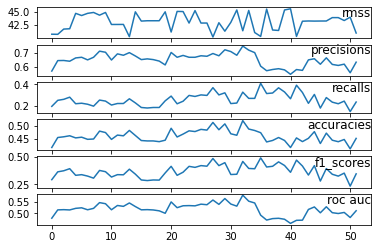

In [155]:
df_perform_msft = plot_lag_to_performance(name='Microsoft', df_stock=[df_msft])

In [156]:
best_msft = df_perform_msft[df_perform_msft["accuracies"] == max(df_perform_msft["accuracies"])]  # 23 (5 months)
df_perform_msft

,rmss,precisions,recalls,accuracies,f1_scores,roc auc
1,40.787251,0.567568,0.196262,0.413793,0.291667,0.478728
2,40.765358,0.642857,0.252336,0.454023,0.362416,0.514228
3,41.743061,0.643678,0.261682,0.456897,0.372093,0.515169
4,41.803474,0.638298,0.281690,0.461095,0.390879,0.513979
5,44.671631,0.661972,0.220657,0.452450,0.330986,0.520776
6,44.269345,0.666667,0.225352,0.455331,0.336842,0.523124
7,44.673443,0.647887,0.215962,0.446686,0.323944,0.514698
8,44.840907,0.666667,0.198113,0.447977,0.305455,0.520698
9,44.335334,0.710526,0.254717,0.479769,0.375000,0.545269
10,44.839108,0.702703,0.245283,0.473988,0.363636,0.540552


C:\Users\testt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\testt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\testt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\testt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision 

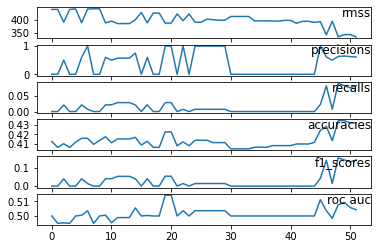

In [157]:
df_perform_ggl = plot_lag_to_performance(name='Google', df_stock=[df_ggl]) #metrixs too bad

In [158]:
best_ggl = df_perform_ggl[df_perform_ggl["accuracies"] == max(df_perform_ggl["accuracies"])]  # 23 (5 months)
df_perform_ggl

,rmss,precisions,recalls,accuracies,f1_scores,roc auc
1,440.081662,0.000000,0.000000,0.412245,0.000000,0.500000
2,440.398539,0.000000,0.000000,0.405738,0.000000,0.495000
3,391.071557,0.500000,0.020833,0.409836,0.040000,0.495417
4,440.398539,0.000000,0.000000,0.405738,0.000000,0.495000
5,441.901634,0.000000,0.000000,0.411523,0.000000,0.500000
6,388.505649,0.600000,0.020979,0.415638,0.040541,0.500490
7,441.875317,1.000000,0.006993,0.415638,0.013889,0.503497
8,442.761995,0.000000,0.000000,0.409091,0.000000,0.495000
9,442.760228,0.000000,0.000000,0.413223,0.000000,0.500000
10,388.192910,0.600000,0.021127,0.417355,0.040816,0.500563


In [159]:
print(best_aapl) #5 months
print(best_msft) #8 months
print(best_ggl) #12 months -- 1 yr

         rmss  precisions   recalls  accuracies  f1_scores   roc auc
23  75.382146    0.557692  0.205674    0.418103   0.300518  0.476463
         rmss  precisions   recalls  accuracies  f1_scores  roc auc
33  41.428092    0.747253  0.328502    0.522124   0.456376  0.57713
          rmss  precisions   recalls  accuracies  f1_scores   roc auc
49  334.265225    0.631579  0.088889    0.434783   0.155844  0.507602
50  342.638658    0.647059  0.081481    0.434783   0.144737  0.509162


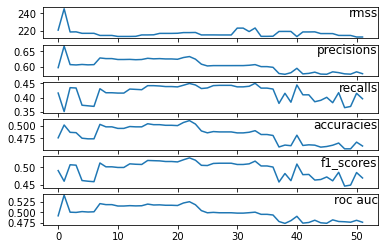

In [160]:
df_perform_all = plot_lag_to_performance(name='All', df_stock=[df_aapl, df_ggl, df_msft])

In [161]:
best_all = df_perform_all[df_perform_all["accuracies"] == max(df_perform_all["accuracies"])]
df_perform_all 

,rmss,precisions,recalls,accuracies,f1_scores,roc auc
1,221.211227,0.596591,0.416667,0.475962,0.490654,0.491870
2,245.256736,0.667925,0.351889,0.501205,0.460937,0.541388
3,219.120577,0.606648,0.435388,0.486747,0.506944,0.500568
4,219.252698,0.605556,0.434263,0.486128,0.505800,0.500006
5,217.594351,0.607143,0.374000,0.475212,0.462871,0.501985
6,217.594342,0.605863,0.372000,0.474002,0.460967,0.500985
7,217.594321,0.606557,0.370000,0.474002,0.459627,0.501514
8,215.205800,0.628655,0.431727,0.502427,0.511905,0.521078
9,215.206198,0.626506,0.417671,0.497573,0.501205,0.518651
10,215.206193,0.626506,0.417671,0.497573,0.501205,0.518651


In [162]:
print(best_all) #23 weeks(5 months)

          rmss  precisions   recalls  accuracies  f1_scores   roc auc
23  218.417581    0.633238  0.450102    0.509852    0.52619  0.525674


## All

In [166]:
def aapl_performance(model_all):
    # AAPL
    x_test_aapl = test_aapl.drop(['Close (t)', 'movement'], axis=1)
    y_test_aapl = test_aapl['Close (t)']

    preds_aapl = model_all.predict(x_test_aapl)
    rms_aapl = np.sqrt(np.mean(np.power((np.array(y_test_aapl)-np.array(preds_aapl)),2)))

    print('Apple-All', 'RMS:', rms_aapl)

    # plot
    df_results = pd.DataFrame()
    df_results['Apple Weekly Close Price (Ground Truth)'] = test_aapl['Close (t)']
    df_results['All Weekly Price Prediction'] = preds_aapl

    plt.plot(df_results['Apple Weekly Close Price (Ground Truth)'])
    plt.plot(df_results['All Weekly Price Prediction'])

    plt.title('Apple-All Weekly with sliding window '+str(23))

    plt.ylabel('Close',fontsize=23)
    plt.legend(['Apple Weekly Close Price (Ground Truth)', 'All Weekly Price Prediction'])
    plt.show()

    move_test_aapl = test_aapl['movement']

    pred_move_aapl = (preds_aapl - test_aapl["Close (t-1)"])
    pred_move_aapl = pred_move_aapl.where(pred_move_aapl<0, 1).where(pred_move_aapl>=0, 0).astype(int)

    precision = precision_score(move_test_aapl, pred_move_aapl)
    recall = recall_score(move_test_aapl, pred_move_aapl)
    accuracy = accuracy_score(move_test_aapl, pred_move_aapl)
    f1 = f1_score(move_test_aapl, pred_move_aapl)

    print(confusion_matrix(move_test_aapl, pred_move_aapl))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    print("metrics.roc_auc_score", str(roc_auc_score(move_test_aapl, pred_move_aapl)))
    
def ggl_performance(model_all):
    # GGL
    x_test_ggl = test_ggl.drop(['Close (t)', 'movement'], axis=1)
    y_test_ggl = test_ggl['Close (t)']

    preds_ggl = model_all.predict(x_test_ggl)
    rms_ggl = np.sqrt(np.mean(np.power((np.array(y_test_ggl)-np.array(preds_ggl)),2)))

    print('Google-All', 'RMS:', rms_ggl)

    # plot
    df_results = pd.DataFrame()
    df_results['Google Weekly Close Price (Ground Truth)'] = test_ggl['Close (t)']
    df_results['All Weekly Price Prediction'] = preds_ggl

    plt.plot(df_results['Google Weekly Close Price (Ground Truth)'])
    plt.plot(df_results['All Weekly Price Prediction'])

    plt.title('Google-All Weekly with sliding window '+str(18))

    plt.ylabel('Close',fontsize=18)
    plt.legend(['Google Weekly Close Price (Ground Truth)', 'All Weekly Price Prediction'])
    plt.show()


    move_test_ggl = test_ggl['movement']

    pred_move_ggl = (preds_ggl - test_ggl["Close (t-1)"])
    pred_move_ggl = pred_move_ggl.where(pred_move_ggl<0, 1).where(pred_move_ggl>=0, 0).astype(int)

    precision = precision_score(move_test_ggl, pred_move_ggl)
    recall = recall_score(move_test_ggl, pred_move_ggl)
    accuracy = accuracy_score(move_test_ggl, pred_move_ggl)
    f1 = f1_score(move_test_ggl, pred_move_ggl)

    print(confusion_matrix(move_test_ggl, pred_move_ggl))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    print("metrics.roc_auc_score", str(roc_auc_score(move_test_ggl, pred_move_ggl)))

def msft_performance(model_all):
    # MSFT
    x_test_msft = test_msft.drop(['Close (t)', 'movement'], axis=1)
    y_test_msft = test_msft['Close (t)']

    preds_msft = model_all.predict(x_test_msft)
    rms_msft = np.sqrt(np.mean(np.power((np.array(y_test_msft)-np.array(preds_msft)),2)))

    print('Microsoft-All', 'RMS:', rms_msft)

    # plot
    df_results = pd.DataFrame()
    df_results['Microsoft Weekly Close Price (Ground Truth)'] = test_msft['Close (t)']
    df_results['All Weekly Price Prediction'] = preds_msft

    plt.plot(df_results['Microsoft Weekly Close Price (Ground Truth)'])
    plt.plot(df_results['All Weekly Price Prediction'])

    plt.title('Microsoft-All Weekly with sliding window '+str(23))

    plt.ylabel('Close',fontsize=18)
    plt.legend(['Microsoft Weekly Close Price (Ground Truth)', 'All Weekly Price Prediction'])
    plt.show()

    move_test_msft = test_msft['movement']

    pred_move_msft = (preds_msft - test_msft["Close (t-1)"])
    pred_move_msft = pred_move_msft.where(pred_move_msft<0, 1).where(pred_move_msft>=0, 0).astype(int)

    precision = precision_score(move_test_msft, pred_move_msft)
    recall = recall_score(move_test_msft, pred_move_msft)
    accuracy = accuracy_score(move_test_msft, pred_move_msft)
    f1 = f1_score(move_test_msft, pred_move_msft)

    print(confusion_matrix(move_test_msft, pred_move_msft))
    print('Precision: %.3f' % precision)
    print('Recall: %.3f' % recall)
    print('Accuracy: %.3f' % accuracy)
    print('F1-score: %.3f\n' % f1)
    print("metrics.roc_auc_score", str(roc_auc_score(move_test_msft, pred_move_msft)))

### XGB

In [164]:
import xgboost as xgb
train_all, test_all = generate_train_test(23, datasets=[df_aapl, df_ggl, df_msft])
_, test_aapl = generate_train_test(23, datasets=[df_aapl])
_, test_ggl = generate_train_test(23, datasets=[df_ggl])
_, test_msft = generate_train_test(23, datasets=[df_msft])

model_all = xgb.XGBRegressor(random_state=42)
params = {
        'learning_rate': [x/10 for x in list(range(1,6))],
        'max_depth': [3, 4, 5]
        }
model_all = GridSearchCV(model_all, params, scoring='neg_root_mean_squared_error')
x_train_all = train_all.drop(['Close (t)', 'movement'], axis=1)
y_train_all = train_all['Close (t)']
model_all.fit(x_train_all, y_train_all)
print(model_all.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


Apple-All RMS: 11.798214317199204


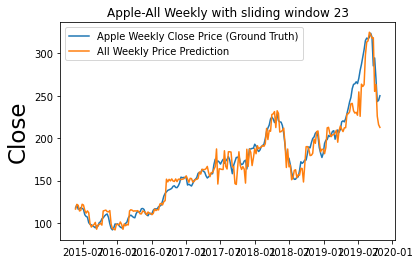

[[50 41]
 [73 68]]
Precision: 0.624
Recall: 0.482
Accuracy: 0.509
F1-score: 0.544

metrics.roc_auc_score 0.5158600264983244
Google-All RMS: 401.9051107307892


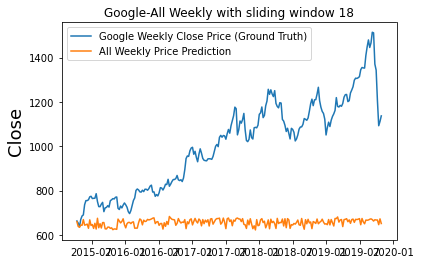

[[ 97   0]
 [139   2]]
Precision: 1.000
Recall: 0.014
Accuracy: 0.416
F1-score: 0.028

metrics.roc_auc_score 0.5070921985815603
Microsoft-All RMS: 5.28295661842995


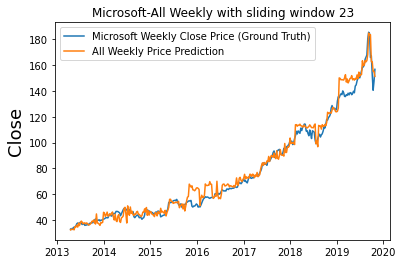

[[ 53  80]
 [ 61 148]]
Precision: 0.649
Recall: 0.708
Accuracy: 0.588
F1-score: 0.677

metrics.roc_auc_score 0.553315105946685


In [167]:
aapl_performance(model_all)
ggl_performance(model_all)
msft_performance(model_all)

### Gradient Boosting

In [168]:
train_all, test_all = generate_train_test(23, datasets=[df_aapl, df_ggl, df_msft])
_, test_aapl = generate_train_test(23, datasets=[df_aapl])
_, test_ggl = generate_train_test(23, datasets=[df_ggl])
_, test_msft = generate_train_test(23, datasets=[df_msft])

model_all = GradientBoostingRegressor(random_state=42)
params = {
        'learning_rate': [x/10 for x in list(range(1,6))],
        'max_depth': [3, 4, 5]
        }
model_all = GridSearchCV(model_all, params, scoring='neg_root_mean_squared_error')
x_train_all = train_all.drop(['Close (t)', 'movement'], axis=1)
y_train_all = train_all['Close (t)']
model_all.fit(x_train_all, y_train_all)
print(model_all.best_estimator_)

GradientBoostingRegressor(learning_rate=0.3, random_state=42)


Apple-All RMS: 7.189801715651047


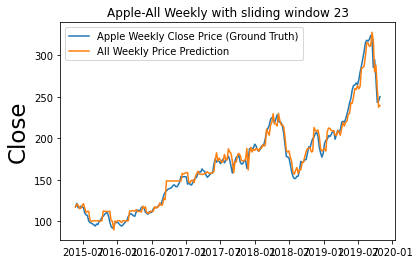

[[32 59]
 [50 91]]
Precision: 0.607
Recall: 0.645
Accuracy: 0.530
F1-score: 0.625

metrics.roc_auc_score 0.49851921128516874
Google-All RMS: 407.5056709807643


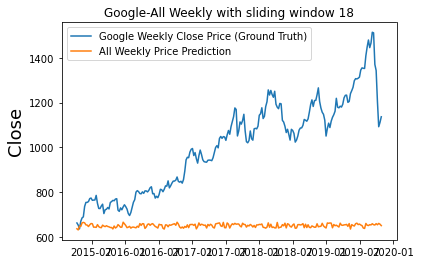

[[ 97   0]
 [140   1]]
Precision: 1.000
Recall: 0.007
Accuracy: 0.412
F1-score: 0.014

metrics.roc_auc_score 0.5035460992907801
Microsoft-All RMS: 4.3270846585110965


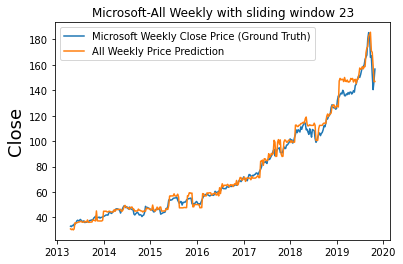

[[ 53  80]
 [ 60 149]]
Precision: 0.651
Recall: 0.713
Accuracy: 0.591
F1-score: 0.680

metrics.roc_auc_score 0.5557074504442925


In [169]:
aapl_performance(model_all)
ggl_performance(model_all)
msft_performance(model_all)

### Random Forest Regressor

In [170]:
train_all, test_all = generate_train_test(23, datasets=[df_aapl, df_ggl, df_msft])
_, test_aapl = generate_train_test(23, datasets=[df_aapl])
_, test_ggl = generate_train_test(23, datasets=[df_ggl])
_, test_msft = generate_train_test(23, datasets=[df_msft])

model_all = RandomForestRegressor(random_state=42)
params = {
        'max_depth': [3, 4, 5]
        }
model_all = GridSearchCV(model_all, params, scoring='neg_root_mean_squared_error')
x_train_all = train_all.drop(['Close (t)', 'movement'], axis=1)
y_train_all = train_all['Close (t)']
model_all.fit(x_train_all, y_train_all)
print(model_all.best_estimator_)

RandomForestRegressor(max_depth=5, random_state=42)


Apple-All RMS: 7.040458009945641


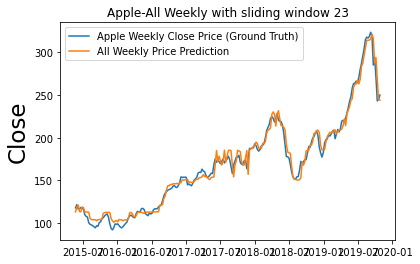

[[30 61]
 [51 90]]
Precision: 0.596
Recall: 0.638
Accuracy: 0.517
F1-score: 0.616

metrics.roc_auc_score 0.4839841010053776
Google-All RMS: 405.40882092911374


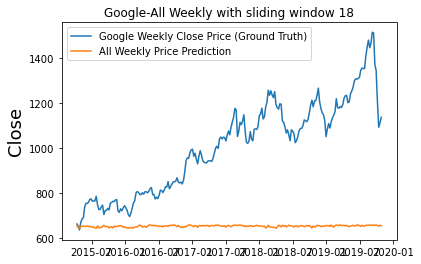

[[ 97   0]
 [139   2]]
Precision: 1.000
Recall: 0.014
Accuracy: 0.416
F1-score: 0.028

metrics.roc_auc_score 0.5070921985815603
Microsoft-All RMS: 3.591739675233357


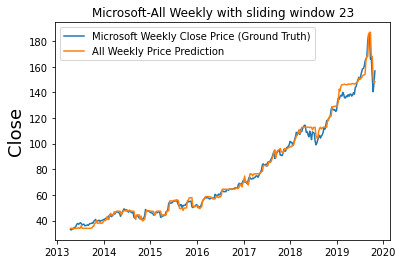

[[ 48  85]
 [ 80 129]]
Precision: 0.603
Recall: 0.617
Accuracy: 0.518
F1-score: 0.610

metrics.roc_auc_score 0.4890635680109364


In [171]:
aapl_performance(model_all)
ggl_performance(model_all)
msft_performance(model_all)

### Simple Decision Tree Regressor

In [172]:
train_all, test_all = generate_train_test(23, datasets=[df_aapl, df_ggl, df_msft])
_, test_aapl = generate_train_test(23, datasets=[df_aapl])
_, test_ggl = generate_train_test(23, datasets=[df_ggl])
_, test_msft = generate_train_test(23, datasets=[df_msft])

model_all = DecisionTreeRegressor(random_state=42)
params = {
        'max_depth': [3, 4, 5]
        }
model_all = GridSearchCV(model_all, params, scoring='neg_root_mean_squared_error')
x_train_all = train_all.drop(['Close (t)', 'movement'], axis=1)
y_train_all = train_all['Close (t)']
model_all.fit(x_train_all, y_train_all)
print(model_all.best_estimator_)

DecisionTreeRegressor(max_depth=5, random_state=42)


Apple-All RMS: 7.1347643464915285


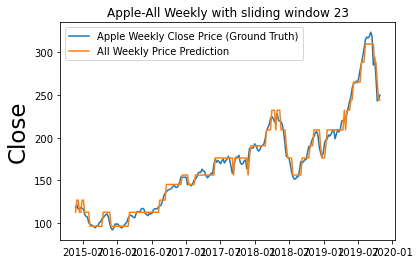

[[40 51]
 [48 93]]
Precision: 0.646
Recall: 0.660
Accuracy: 0.573
F1-score: 0.653

metrics.roc_auc_score 0.5495674538227729
Google-All RMS: 403.3298086258998


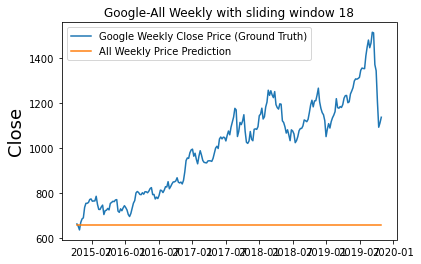

[[ 96   1]
 [139   2]]
Precision: 0.667
Recall: 0.014
Accuracy: 0.412
F1-score: 0.028

metrics.roc_auc_score 0.5019375594063026
Microsoft-All RMS: 5.136207809741646


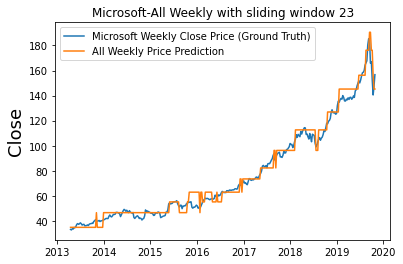

[[ 57  76]
 [ 83 126]]
Precision: 0.624
Recall: 0.603
Accuracy: 0.535
F1-score: 0.613

metrics.roc_auc_score 0.5157211209842789


In [173]:
aapl_performance(model_all)
ggl_performance(model_all)
msft_performance(model_all)